# Advanced Modeling: SMOTE Experiment
## SMOTE Oversampling vs Class Weight Comparison

This notebook tests SMOTE (Synthetic Minority Oversampling Technique) as an 
alternative to class_weight for handling class imbalance in churn prediction.

**Objective:** Determine if SMOTE can improve recall beyond our current 
57.84% (catching churners) without sacrificing too much precision.

**Current Approach:** class_weight={0:1, 1:2} (2× penalty for missing churners)

**SMOTE Approach:** Generate synthetic minority samples to balance classes

**Key Question:** Does SMOTE help us catch more churners, or just create 
noise that hurts overall performance?

## 1. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path
from collections import Counter

# Sklearn models and utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)

# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

# Custom utilities
from advanced_modeling_utils import (
    load_preprocessed_data,
    compare_models_results,
    visualize_smote_impact,
    save_experiment_results
)

# Settings
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Load Preprocessed Data

Use the utility function to load data with identical preprocessing as 
03_churn_prediction.

In [4]:
# Load data with consistent preprocessing
X_train, X_test, y_train, y_test, feature_names = load_preprocessed_data()

print(f"✓ Data loaded successfully")
print(f"\nData Summary:")
print(f"  Train shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")
print(f"  Features: {len(feature_names)}")
print(f"  Train churn rate: {y_train.mean():.2%}")
print(f"  Test churn rate: {y_test.mean():.2%}")

✓ Data loaded successfully

Data Summary:
  Train shape: (8000, 13)
  Test shape: (2000, 13)
  Features: 13
  Train churn rate: 20.38%
  Test churn rate: 20.40%


## 3. Baseline: Random Forest with Class Weight

Train Random Forest with class_weight (current approach from 03_churn_prediction).
This is our baseline for comparison.

In [5]:
print("="*80)
print("BASELINE: RANDOM FOREST WITH CLASS WEIGHT")
print("="*80)

rf_classweight = RandomForestClassifier(
    n_estimators=900,
    max_depth=11,
    criterion='gini',
    max_features=None,
    min_samples_split=4,
    min_samples_leaf=1,
    class_weight={0:1, 1:2},  # Current approach
    random_state=42,
    n_jobs=-1
)

print("\n🔨 Training Random Forest with class_weight...")
rf_classweight.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate
rf_cw_pred = rf_classweight.predict(X_test)
rf_cw_proba = rf_classweight.predict_proba(X_test)[:, 1]

rf_cw_accuracy = accuracy_score(y_test, rf_cw_pred)
rf_cw_precision = precision_score(y_test, rf_cw_pred)
rf_cw_recall = recall_score(y_test, rf_cw_pred)
rf_cw_f1 = f1_score(y_test, rf_cw_pred)
rf_cw_roc = roc_auc_score(y_test, rf_cw_proba)

print(f"\n📊 Class Weight Performance:")
print(f"  Accuracy:  {rf_cw_accuracy:.4f} ({rf_cw_accuracy*100:.2f}%)")
print(f"  Precision: {rf_cw_precision:.4f} ({rf_cw_precision*100:.2f}%)")
print(f"  Recall:    {rf_cw_recall:.4f} ({rf_cw_recall*100:.2f}%)")
print(f"  F1-Score:  {rf_cw_f1:.4f} ({rf_cw_f1*100:.2f}%)")
print(f"  ROC-AUC:   {rf_cw_roc:.4f} ({rf_cw_roc*100:.2f}%)")

BASELINE: RANDOM FOREST WITH CLASS WEIGHT

🔨 Training Random Forest with class_weight...
✓ Training complete

📊 Class Weight Performance:
  Accuracy:  0.8585 (85.85%)
  Precision: 0.6801 (68.01%)
  Recall:    0.5784 (57.84%)
  F1-Score:  0.6252 (62.52%)
  ROC-AUC:   0.8585 (85.85%)


## 4. Apply SMOTE to Training Data

SMOTE creates synthetic samples of the minority class (churners) to balance 
the training set. Important: SMOTE is applied ONLY to training data, never 
to test data.

In [6]:
print("\n" + "="*80)
print("APPLYING SMOTE TO TRAINING DATA")
print("="*80)

# Show original class distribution
print("\n📊 Original Class Distribution:")
print(f"  Not Churn: {Counter(y_train)[0]} ({Counter(y_train)[0]/len(y_train)*100:.1f}%)")
print(f"  Churn:     {Counter(y_train)[1]} ({Counter(y_train)[1]/len(y_train)*100:.1f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n📊 After SMOTE Class Distribution:")
print(f"  Not Churn: {Counter(y_train_smote)[0]} ({Counter(y_train_smote)[0]/len(y_train_smote)*100:.1f}%)")
print(f"  Churn:     {Counter(y_train_smote)[1]} ({Counter(y_train_smote)[1]/len(y_train_smote)*100:.1f}%)")
print(f"\n  Synthetic samples created: {len(y_train_smote) - len(y_train)}")


APPLYING SMOTE TO TRAINING DATA

📊 Original Class Distribution:
  Not Churn: 6370 (79.6%)
  Churn:     1630 (20.4%)

📊 After SMOTE Class Distribution:
  Not Churn: 6370 (50.0%)
  Churn:     6370 (50.0%)

  Synthetic samples created: 4740


## 5. Visualize SMOTE Impact

Visualize how SMOTE balances the class distribution.

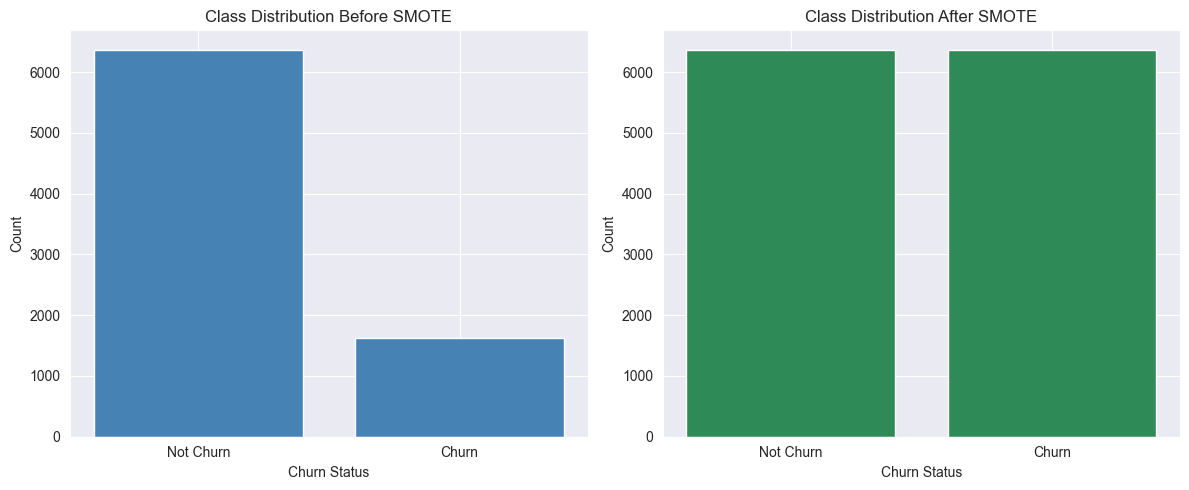

In [7]:
# Visualize SMOTE impact
visualize_smote_impact(y_train, y_train_smote)

## 6. Train Random Forest with SMOTE Data

Train Random Forest on SMOTE-balanced data WITHOUT class_weight 
(since classes are now balanced).

In [8]:
print("\n" + "="*80)
print("TRAINING: RANDOM FOREST WITH SMOTE DATA")
print("="*80)

rf_smote = RandomForestClassifier(
    n_estimators=900,
    max_depth=11,
    criterion='gini',
    max_features=None,
    min_samples_split=4,
    min_samples_leaf=1,
    # No class_weight needed (SMOTE balanced the classes)
    random_state=42,
    n_jobs=-1
)

print("\n🔨 Training Random Forest on SMOTE data...")
rf_smote.fit(X_train_smote, y_train_smote)
print("✓ Training complete")

# Evaluate on ORIGINAL test set (SMOTE never touched test data)
rf_smote_pred = rf_smote.predict(X_test)
rf_smote_proba = rf_smote.predict_proba(X_test)[:, 1]

rf_smote_accuracy = accuracy_score(y_test, rf_smote_pred)
rf_smote_precision = precision_score(y_test, rf_smote_pred)
rf_smote_recall = recall_score(y_test, rf_smote_pred)
rf_smote_f1 = f1_score(y_test, rf_smote_pred)
rf_smote_roc = roc_auc_score(y_test, rf_smote_proba)

print(f"\n📊 SMOTE Performance:")
print(f"  Accuracy:  {rf_smote_accuracy:.4f} ({rf_smote_accuracy*100:.2f}%)")
print(f"  Precision: {rf_smote_precision:.4f} ({rf_smote_precision*100:.2f}%)")
print(f"  Recall:    {rf_smote_recall:.4f} ({rf_smote_recall*100:.2f}%)")
print(f"  F1-Score:  {rf_smote_f1:.4f} ({rf_smote_f1*100:.2f}%)")
print(f"  ROC-AUC:   {rf_smote_roc:.4f} ({rf_smote_roc*100:.2f}%)")


TRAINING: RANDOM FOREST WITH SMOTE DATA

🔨 Training Random Forest on SMOTE data...
✓ Training complete

📊 SMOTE Performance:
  Accuracy:  0.8255 (82.55%)
  Precision: 0.5618 (56.18%)
  Recall:    0.6569 (65.69%)
  F1-Score:  0.6056 (60.56%)
  ROC-AUC:   0.8496 (84.96%)


## 7. Side-by-Side Comparison

Compare class_weight vs SMOTE approaches.

In [9]:
print("\n" + "="*80)
print("SMOTE vs CLASS WEIGHT COMPARISON")
print("="*80)

comparison_results = {
    'Class Weight': (rf_cw_pred, rf_cw_proba),
    'SMOTE': (rf_smote_pred, rf_smote_proba)
}

comparison_df = compare_models_results(comparison_results, y_test)
print("\n")
print(comparison_df.to_string(index=False))


SMOTE vs CLASS WEIGHT COMPARISON


       Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Class Weight    0.8585   0.680115 0.578431  0.625166 0.858506
       SMOTE    0.8255   0.561845 0.656863  0.605650 0.849580


## 8. Confusion Matrix Comparison

Visualize differences in confusion matrices.

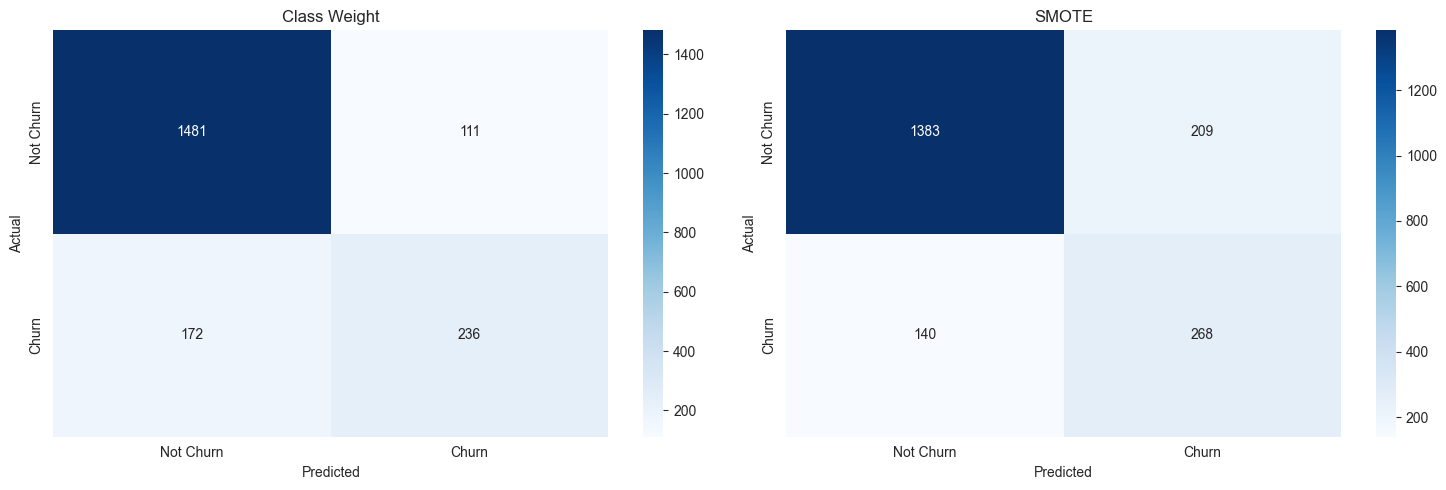

In [10]:
# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, (name, pred) in enumerate([('Class Weight', rf_cw_pred), ('SMOTE', rf_smote_pred)]):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Not Churn', 'Churn'],
               yticklabels=['Not Churn', 'Churn'])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 9. ROC Curve Comparison

Compare ROC curves for both approaches.

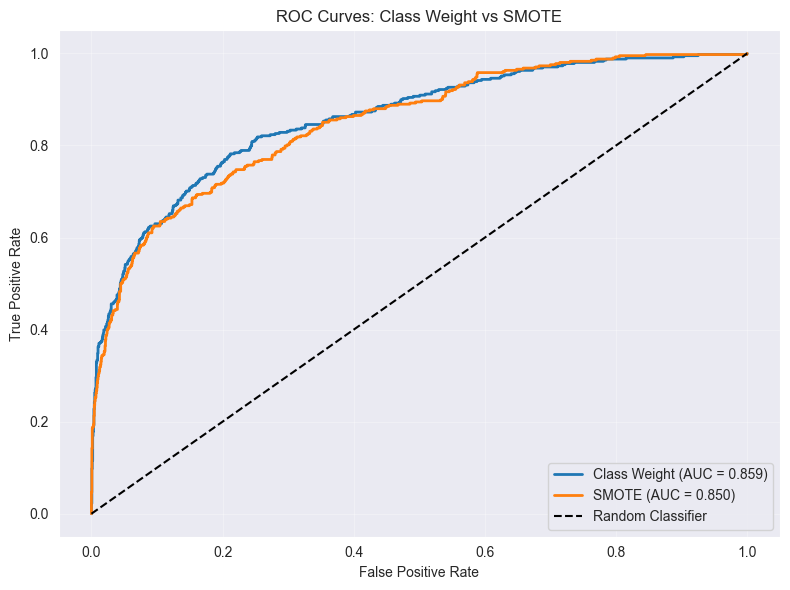

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, proba in [('Class Weight', rf_cw_proba), ('SMOTE', rf_smote_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Class Weight vs SMOTE')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Detailed Metrics Comparison

Break down the specific differences between approaches.

In [12]:
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON")
print("="*80)

metrics_comparison = pd.DataFrame({
    'Approach': ['Class Weight', 'SMOTE', 'Difference'],
    'Accuracy': [rf_cw_accuracy, rf_smote_accuracy, rf_smote_accuracy - rf_cw_accuracy],
    'Precision': [rf_cw_precision, rf_smote_precision, rf_smote_precision - rf_cw_precision],
    'Recall': [rf_cw_recall, rf_smote_recall, rf_smote_recall - rf_cw_recall],
    'F1-Score': [rf_cw_f1, rf_smote_f1, rf_smote_f1 - rf_cw_f1],
    'ROC-AUC': [rf_cw_roc, rf_smote_roc, rf_smote_roc - rf_cw_roc]
})

print("\n")
print(metrics_comparison.to_string(index=False))


DETAILED METRICS COMPARISON


    Approach  Accuracy  Precision   Recall  F1-Score   ROC-AUC
Class Weight    0.8585   0.680115 0.578431  0.625166  0.858506
       SMOTE    0.8255   0.561845 0.656863  0.605650  0.849580
  Difference   -0.0330  -0.118270 0.078431 -0.019516 -0.008926


## 11. Business Impact Analysis

Analyze the business implications of each approach.

In [13]:
print("\n" + "="*80)
print("BUSINESS IMPACT ANALYSIS")
print("="*80)

# Calculate confusion matrix values
cw_cm = confusion_matrix(y_test, rf_cw_pred)
smote_cm = confusion_matrix(y_test, rf_smote_pred)

print("\n📊 Confusion Matrix Breakdown:")
print(f"\nClass Weight Approach:")
print(f"  True Positives (Correctly identified churners):  {cw_cm[1,1]}")
print(f"  False Positives (False alarms):                  {cw_cm[0,1]}")
print(f"  False Negatives (Missed churners):              {cw_cm[1,0]}")
print(f"  True Negatives (Correctly identified retainers): {cw_cm[0,0]}")

print(f"\nSMOTE Approach:")
print(f"  True Positives (Correctly identified churners):  {smote_cm[1,1]}")
print(f"  False Positives (False alarms):                  {smote_cm[0,1]}")
print(f"  False Negatives (Missed churners):              {smote_cm[1,0]}")
print(f"  True Negatives (Correctly identified retainers): {smote_cm[0,0]}")

# Calculate differences
tp_diff = smote_cm[1,1] - cw_cm[1,1]
fp_diff = smote_cm[0,1] - cw_cm[0,1]
fn_diff = smote_cm[1,0] - cw_cm[1,0]

print(f"\n🔄 Differences (SMOTE - Class Weight):")
print(f"  Additional churners caught:     {tp_diff:+d}")
print(f"  Additional false alarms:         {fp_diff:+d}")
print(f"  Fewer missed churners:          {fn_diff:+d}")


BUSINESS IMPACT ANALYSIS

📊 Confusion Matrix Breakdown:

Class Weight Approach:
  True Positives (Correctly identified churners):  236
  False Positives (False alarms):                  111
  False Negatives (Missed churners):              172
  True Negatives (Correctly identified retainers): 1481

SMOTE Approach:
  True Positives (Correctly identified churners):  268
  False Positives (False alarms):                  209
  False Negatives (Missed churners):              140
  True Negatives (Correctly identified retainers): 1383

🔄 Differences (SMOTE - Class Weight):
  Additional churners caught:     +32
  Additional false alarms:         +98
  Fewer missed churners:          -32


## 12. Classification Reports

Detailed per-class performance breakdown.

In [14]:
print("\n" + "="*80)
print("CLASSIFICATION REPORTS")
print("="*80)

print("\n📋 Class Weight Approach:")
print(classification_report(y_test, rf_cw_pred, target_names=['Not Churn', 'Churn']))

print("\n📋 SMOTE Approach:")
print(classification_report(y_test, rf_smote_pred, target_names=['Not Churn', 'Churn']))


CLASSIFICATION REPORTS

📋 Class Weight Approach:
              precision    recall  f1-score   support

   Not Churn       0.90      0.93      0.91      1592
       Churn       0.68      0.58      0.63       408

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000


📋 SMOTE Approach:
              precision    recall  f1-score   support

   Not Churn       0.91      0.87      0.89      1592
       Churn       0.56      0.66      0.61       408

    accuracy                           0.83      2000
   macro avg       0.73      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000



## 13. Save Results

Save experiment results for future reference.

In [15]:
# Prepare results dictionary
results = {
    'models': {
        'Class Weight': rf_classweight,
        'SMOTE': rf_smote
    },
    'predictions': {
        'Class Weight': rf_cw_pred,
        'SMOTE': rf_smote_pred
    },
    'probabilities': {
        'Class Weight': rf_cw_proba,
        'SMOTE': rf_smote_proba
    },
    'metrics': comparison_df.to_dict('records'),
    'smote_impact': {
        'original_samples': len(y_train),
        'after_smote_samples': len(y_train_smote),
        'synthetic_samples': len(y_train_smote) - len(y_train)
    },
    'feature_names': feature_names
}

# Save results
save_experiment_results(results, 'smote_comparison_results.pkl')

✓ Results saved to results/smote_comparison_results.pkl


## 14. Conclusions & Recommendations

Based on the comparison results:

In [16]:
print("\n" + "="*80)
print("CONCLUSIONS & RECOMMENDATIONS")
print("="*80)

# Calculate improvements
recall_improvement = rf_smote_recall - rf_cw_recall
precision_change = rf_smote_precision - rf_cw_precision
f1_change = rf_smote_f1 - rf_cw_f1

print(f"\n📊 Performance Changes:")
print(f"  Recall change:   {recall_improvement:+.4f} ({recall_improvement*100:+.2f}%)")
print(f"  Precision change: {precision_change:+.4f} ({precision_change*100:+.2f}%)")
print(f"  F1-Score change:  {f1_change:+.4f} ({f1_change*100:+.2f}%)")

print(f"\n{'='*80}")
print("RECOMMENDATION:")
print(f"{'='*80}")

if recall_improvement > 0.03:  # More than 3% improvement
    print("\n✓ SMOTE significantly improves recall.")
    print(f"  Improvement: +{recall_improvement*100:.2f}% recall")
    print("\n  Consider adopting SMOTE if:")
    print("    - Recall improvement >3% justifies added complexity")
    print("    - False alarm increase is acceptable for business")
    print("    - Higher computational cost is manageable")
elif recall_improvement > 0 and recall_improvement <= 0.03:
    print("\n⚠ SMOTE slightly improves recall but adds complexity.")
    print(f"  Improvement: +{recall_improvement*100:.2f}% recall")
    print("\n  Recommendation: Stick with class_weight")
    print("    - Marginal benefit doesn't justify added complexity")
    print("    - class_weight is simpler and more interpretable")
    print("    - SMOTE creates synthetic samples (less transparent)")
else:
    print("\n✗ SMOTE hurts performance.")
    print(f"  Recall change: {recall_improvement*100:.2f}%")
    print("\n  Recommendation: Continue using class_weight")
    print("    - class_weight performs better")
    print("    - Simpler and more transparent")
    print("    - SMOTE may introduce unrealistic synthetic patterns")

print(f"\n{'='*80}")
print("END OF SMOTE EXPERIMENT")
print(f"{'='*80}")


CONCLUSIONS & RECOMMENDATIONS

📊 Performance Changes:
  Recall change:   +0.0784 (+7.84%)
  Precision change: -0.1183 (-11.83%)
  F1-Score change:  -0.0195 (-1.95%)

RECOMMENDATION:

✓ SMOTE significantly improves recall.
  Improvement: +7.84% recall

  Consider adopting SMOTE if:
    - Recall improvement >3% justifies added complexity
    - False alarm increase is acceptable for business
    - Higher computational cost is manageable

END OF SMOTE EXPERIMENT
